In [103]:
import plotly.express as px
import os
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon
import folium
from openrouteservice import client
from shapely import geometry
from shapely.geometry import shape, Polygon, mapping, MultiPolygon, LineString, Point
from shapely.ops import cascaded_union, transform
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
import pandas as pd
import os
from geopy.distance import distance
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import seaborn as sns
from shapely.geometry import box
import geopandas as gpd
import earthpy as et
from random import uniform
from folium.plugins import TimestampedGeoJson
import overpy
import requests
import json
import rtree.index
from math import radians, cos, sin, asin, sqrt
import pyproj
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.corpus import stopwords
import nltk
from shapely.geometry import Point
import re
from nltk.tokenize import word_tokenize
import string
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import geopy
import xgboost as xgb
from xgboost import XGBRegressor
from scipy import stats
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
import joblib
import pickle

In [14]:
df = pd.read_csv('train.csv')

In [15]:
df.describe()

,id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,price
count,5.181500e+04,5.181500e+04,51815.000000,51815.000000,51815.000000,51812.000000,51796.000000,51743.000000,15.000000,33897.000000,38364.000000,51815.000000,51815.000000,51815.000000,51815.000000
mean,2.238119e+07,8.122630e+07,51.509058,-0.127937,3.225089,1.294227,1.399027,1.773438,991.133333,192.249019,42.472891,1.561401,7.052359,3.959548,115.015787
std,4.648209e+06,6.712667e+07,0.045575,0.092781,2.002458,0.620269,0.907317,1.224066,933.178965,310.090851,44.525508,1.282639,13.353841,13.994390,201.599587
min,1.278600e+05,4.775000e+03,51.294794,-0.501305,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,1.874920e+07,2.049720e+07,51.486162,-0.187733,2.000000,1.000000,1.000000,1.000000,242.000000,0.000000,15.000000,1.000000,0.000000,1.000000,45.000000
50%,2.235012e+07,6.358767e+07,51.513346,-0.126478,2.000000,1.000000,1.000000,1.000000,753.000000,100.000000,30.000000,1.000000,0.000000,2.000000,80.000000
75%,2.655883e+07,1.362233e+08,51.535516,-0.070239,4.000000,1.500000,2.000000,2.000000,1600.000000,250.000000,60.000000,2.000000,10.000000,3.000000,135.000000
max,2.979850e+07,2.241824e+08,51.679199,0.285395,20.000000,14.000000,12.000000,16.000000,3000.000000,4098.000000,614.000000,30.000000,235.000000,1125.000000,13700.000000


In [7]:
#fig = px.histogram(df, x="price")
#fig.show()

In [8]:
#fig = px.box(df, x="price")
#fig.show()

In [23]:
def preprocessing(df, MODE):
    center = Point((-0.1424,51.5023), 4326)
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    gdf = df.select_dtypes(include=numerics)
    newdf = gpd.GeoDataFrame(
    gdf, geometry = gpd.points_from_xy(x=gdf.longitude, y=gdf.latitude)
    )
    column_means = newdf.median()
    newdf = newdf.fillna(column_means)
    newdf["bathrooms"] = newdf["bathrooms"].astype(float).astype(int)
    newdf["bedrooms"] = newdf["bedrooms"].astype(float).astype(int)
    newdf["beds"] = newdf["beds"].astype(float).astype(int)
    newdf["extra_people"] = newdf["extra_people"].astype(float).astype(int)
    newdf = newdf.drop(['id','latitude','longitude','host_id', 'square_feet'], axis = 1)
    newdf['london'] = 0
    for index, row in newdf.iterrows():
        newdf.loc[index,'london'] = haversine(center.x,center.y,row['geometry'].x,row['geometry'].y)
    newdf = newdf.drop(['geometry','beds','bedrooms','bathrooms','guests_included'], axis = 1)
    if MODE == 'train':
        newdf = newdf[newdf['price'] > 0]
        sns.heatmap(newdf.corr())
        return newdf
    return newdf
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a)) 
    r = 6371
    return c * r
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

34.717166731764785


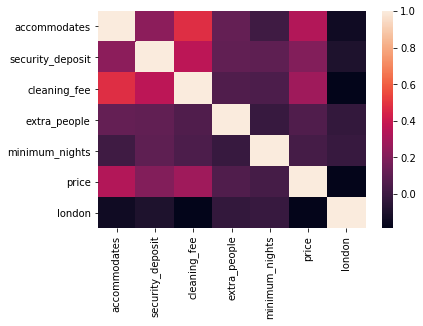

In [24]:
new = preprocessing(df, 'train')
X_train, X_test = train_test_split(new, test_size=0.2, random_state=0)
X_train = X_train[X_train['price'] < 120]
y_train = X_train['price']
X_train = X_train.drop(['price',], axis = 1)
X_train[(np.abs(stats.zscore(X_train)) < 3).all(axis=1)]
X_test = X_test[X_test['price'] > 0]
y_test = X_test['price']
X_test = X_test.drop(['price',], axis = 1)
min_max_scaler = MinMaxScaler()
X_train_ss = min_max_scaler.fit_transform(X_train)
X_test_ss = min_max_scaler.transform(X_test)
weight = round(1 / y_train, 2)
logisticRegr = CatBoostRegressor()
logisticRegr.fit(X_train_ss, np.log1p(y_train), sample_weight = weight, verbose=False)
y_pred = np.expm1(logisticRegr.predict(X_test_ss))
print (mean_absolute_percentage_error(y_test,y_pred))


In [25]:
ft_weights_xgb_reg = pd.DataFrame(logisticRegr.feature_importances_, index=X_train.columns)
ft_weights_xgb_reg

,0
accommodates,24.927694
security_deposit,5.837217
cleaning_fee,19.236201
extra_people,8.729679
minimum_nights,13.192764
london,28.076446


In [98]:
x_test = [5,0,1,0,0,3]
x_arr = np.array(x_test)
y = np.expm1(logisticRegr.predict(x_arr))
print(y)


72.51819312481861


In [104]:
with open('logisticRegr.pkl', 'wb') as output_file:
    pickle.dump(logisticRegr, output_file)

In [259]:
df_test = pd.read_csv('test.csv')
df_test = preprocessing(df_test,'test')


In [260]:
df_test_ss = min_max_scaler.transform(df_test)

In [261]:
df_sample = pd.read_csv('sample_submission.csv')

In [262]:
df_sample['price'] = logisticRegr.predict(df_test_ss)

In [263]:
df_sample.to_csv('total.csv', header=True, index=False, encoding='utf-8')

In [264]:
df_sample.head()

,id,price
0,9554,34.351536
1,11076,59.689606
2,13913,37.243790
3,17402,86.653732
4,24328,99.640793
